In [20]:
# Importar las librerias a utilizar

from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm.notebook import tqdm
import hiddenlayer as hl

In [21]:
#Recoleccion y randomizacion de datos

train_files = glob('fashion-mnist/train/*/*.png')
valid_files = glob('fashion-mnist/valid/*/*.png')
test_files = glob('fashion-mnist/test/*/*.png')

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

In [22]:
train_files[0]

'fashion-mnist/train\\9\\20766.png'

In [23]:
#Preparacion de los datos

N_train = len(train_files)
X_train = []
Y_train = []
for i, train_file in enumerate(train_files):
  Y_train.append(int(train_file.split('\\')[1]))
  X_train.append(np.array(Image.open(train_file)))
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

N_valid = len(valid_files)
X_valid = []
Y_valid = []
for i, valid_file in enumerate(valid_files):
  Y_valid.append(int(valid_file.split('\\')[1]))
  X_valid.append(np.array(Image.open(valid_file)))
X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

N_test = len(test_files)
X_test = []
Y_test = []
for i, test_file in enumerate(test_files):
  Y_test.append(int(test_file.split('\\')[1]))
  X_test.append(np.array(Image.open(test_file)))
X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

In [24]:
batch_size = 32

train_ds = torch.utils.data.TensorDataset(X_train, Y_train)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [25]:
# Definimos la CNN

model = torch.nn.Sequential(
  torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=4),
  # 28/4 = 7                 -> 7*7*16

  torch.nn.Dropout(p=0.2),

  torch.nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=2),
  # ( (7-2+2*2)/1 ) + 1 = 10   -> 10*10*32

  torch.nn.ReLU(),

  torch.nn.MaxPool2d(kernel_size=5),
  # 10/5 = 2                 -> 2*2*32

  torch.nn.Dropout(p=0.2), 

  torch.nn.Flatten(),
  torch.nn.Linear(2*2*32, 10)
)
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.2, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [26]:
# Criterios de evaluación y el optmizador

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.1)

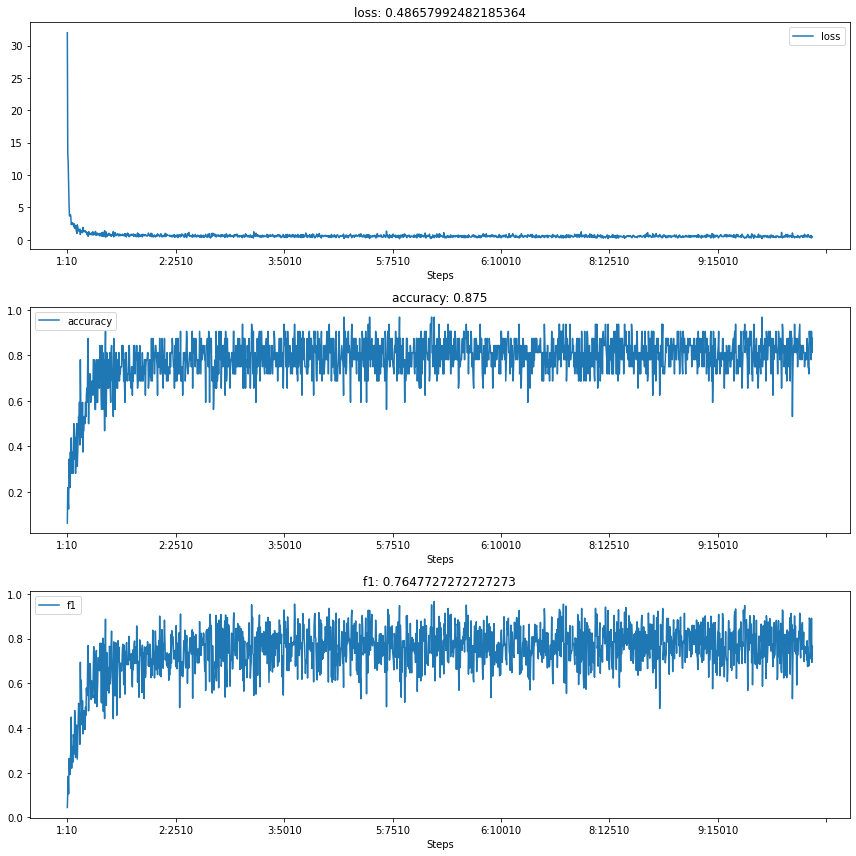

In [27]:
n_epoch = 10

history = hl.History()
canvas = hl.Canvas()

iter = 0

for epoch in range(n_epoch):
  for batch_id, (X_train_batch, Y_train_batch) in enumerate(train_dl):
    model.train()
    #print(X_train_batch.size())
    Xtr = X_train_batch.unsqueeze(1)
    #print(Xtr.size())
    Y_pred = model(Xtr)

    loss = criterion(Y_pred,Y_train_batch)

    Y_pred = torch.argmax(Y_pred, 1)
    f1 = f1_score(Y_train_batch, Y_pred, average='macro')    

    acc = sum(Y_train_batch == Y_pred)/len(Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter += 1

    if iter%10 == 0:
        #-- Visualizamos la evolución de los score loss y accuracy
        history.log((epoch+1, iter), loss=loss, accuracy=acc, f1=f1)
        with canvas:
          canvas.draw_plot(history["loss"])
          canvas.draw_plot(history["accuracy"])
          canvas.draw_plot(history["f1"])

In [36]:
def CM(Y_true, Y_pred, classes):
  fig = plt.figure(figsize=(10, 10))
  cm = confusion_matrix(Y_true, Y_pred)
  lclasses = np.arange(0,classes)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmap=plt.cm.Blues
  ax = fig.add_subplot(1,1,1)
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.86)
  #ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),xticklabels=lclasses, yticklabels=lclasses)
  ax.set_xlabel("Predicted",size=20)
  ax.set_ylabel("True",size=20)
  ax.set_ylim(classes-0.5, -0.5)

  plt.setp(ax.get_xticklabels(), size=12)
  plt.setp(ax.get_yticklabels(), size=12)

  fmt = '.2f'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center",size=15 , color="white" if cm[i, j] > thresh else "black")

  plt.show()


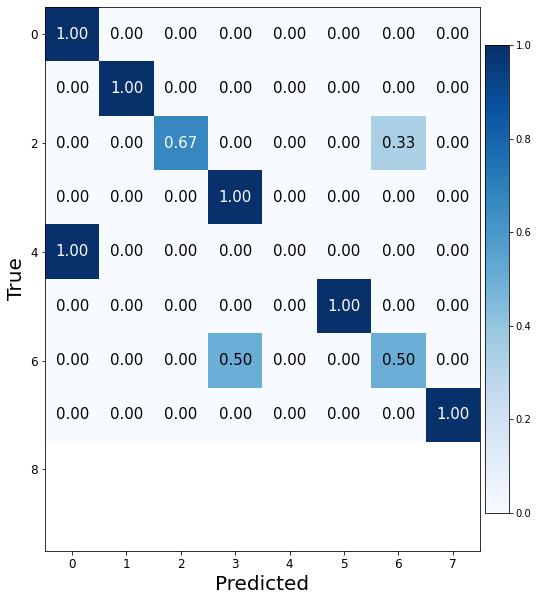

In [37]:
CM(Y_train_batch, Y_pred, 10)

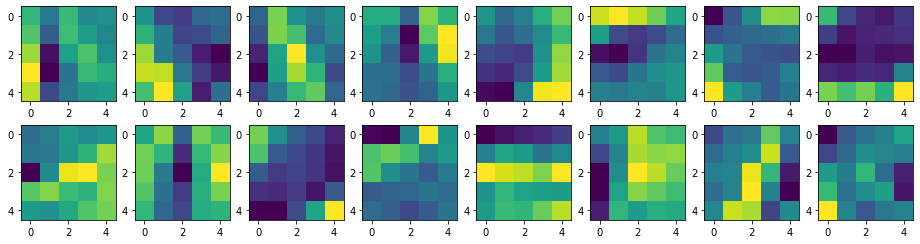

In [82]:
kernels = list(model.children())[0].weight.detach()

fig = plt.figure(figsize=(16,4))
k = 0
for i in range(kernels.size(0)):
    plt.subplot(2488,k+1)
    plt.imshow(kernels[i].squeeze())
    k += 1
plt.show()

# Analisis

Tomamos una red de convolusión con dos capas convolusionales de Max Pooling con diferentes dimensiones. Vemos que es probable que hayamos iterado de más en las épocas de la matriz pues hay convergencia de los valores de f1, accuracy y loss casi al principio del proceso iterativo. Esta idea está reforzada por la matriz de confusión. En esta vemos que las predicciones no son buenas para algunas de las categorías.